# Understanding Graph Convolutional Networks

This notebook presents the fundamentals of **Graph Convolutional Networks** (GCNs) and how to implement a basic Architecture, using **Pytorch Geometric** - to set the stage for a real world **Mobility Data Science** problem - where GCNs can be a huge asset.

As the name suggests GCNs are capable of processing graph-structured data and can be used for a variety of tasks such as Node-level predictions, edge- prediction or graph-level predictions.

In this notebook I will focus on a Node level learning task on randomly generated data to get a feel for GCNs.

Let's dive into it!

## 1. Imports

In [2]:
# For generating random features and graphs:
import numpy as np
import networkx as nx

# For visualizing the graph:
import matplotlib.pyplot as plt

# For implementing the GCN model
from torch_geometric.utils import from_networkx
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

## Let's generate some random Data for our GCN

In this section, I create a Graph for a Node Regression task.
The steps are:
1. **Drawing random samples** from a normal distribution, which will act as the Features of our Nodes.
2. **Constructing the Node Labels** - this variable is simply going to be the linear combination of the node features plus some random noise to add stochasticity.
3. **Constructing the Graph** via Networkx in such a way that nodes with similar labels will be connected. In this way, information is not only stored in the individual features but also in the Graph structure. Hopefully, the GCN model can effectively incorporate knowledge from the neighbors - often referred to as **graph knowledge** - during training.

**Note**: the following approach is a pretty simple one - Graphs in real life can be much more complicated and nuanced.

In [3]:
# Sampling parameters - Note: SampleSize is basically the number of nodes in the Graph
SampleSize = 30
FeatureDim = 2

# Setting the seed for reproducibility
np.random.seed(42)

# Generating random features
NodeFeatures = np.random.normal(size= FeatureDim * SampleSize, loc=3, scale=1).reshape(-1, FeatureDim)


# Generating node labels
NodeLabels = NodeFeatures[:,0]*2 + NodeFeatures[:,1]*0.3 + np.random.normal(size=SampleSize, loc=0, scale=0.5)


print(f'Here you can see the Features of the first 5 Node: \n {NodeFeatures[:5,:]}')
print(f'\n And here you can see the first 5 node label what we want to predict: \n {NodeLabels[:5]}')

Here you can see the Features of the first 5 Node: 
 [[3.49671415 2.8617357 ]
 [3.64768854 4.52302986]
 [2.76584663 2.76586304]
 [4.57921282 3.76743473]
 [2.53052561 3.54256004]]

 And here you can see the first 5 node label what we want to predict: 
 [7.6123619  8.55945654 5.80828468 9.69055274 6.53008215]


### Creating and visualizing the Graph

In this block I initialze a Graph object and iteratively add nodes and edges. The edges are determined via a similarity function in such way that if a pair of nodes are close to each other based on the label then the edge will be set between them. For measuring similarity I used a function that is based on the euclidean distance between pairs - inverting and normalizing it outputs a value between 0 and 1 - where 1 means complete similarity. I set the threshold to 0.5 - **Note**: through this parameter you can control the density of your Graph.


Below you can see the Graph colored by Node Labels and positioned by the Spring Layout Algorithm - Note that the position is not directly determined by the Features we originaly created - it depends on the knots determined by the relations between the nodes. As you can see nodes with similar labels (Which are dependent of the Node Features) are connected to each other - and we expect the GCN can use the information, gathered from the adjacent node features to make predictions on the labels.

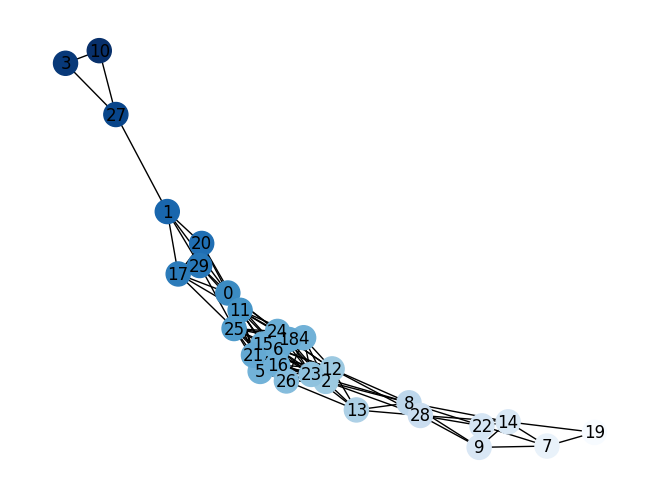

In [4]:
# Create an empty Graph
G = nx.Graph()

# Adding nodes with labels
for i in range(SampleSize):
    G.add_node(i, label=NodeLabels[i])


# For calculating similarity between nodes - based on euclidean distance
def similarity(val1, val2):
    euclidean_dist = np.linalg.norm(val1 - val2) # calculating the euclidean distance
    return 1 / (1 + euclidean_dist) # inverting and normalizing - in this case values closer to 1 indicate that the nodes are similiar, closer to 0 means they are not so similiar

# Adding edges based on similarity
for i in range(SampleSize):
    for j in range(i+1, SampleSize):
        score = similarity(NodeLabels[i], NodeLabels[j])
        if 0.5 < score:
            G.add_edge(i, j)

# Plotting the graph
pos = nx.spring_layout(G)  # Positioning nodes using the spring layout algorithm
nx.draw(G, pos, node_color=NodeLabels, with_labels=True, cmap=plt.cm.Blues)
plt.show()

### Let's see how Graph Knowledge looks like in its simplest form

In Graph Neural Networks we try to incorporate graph knowledge in our model and for this it's necessary to have information about which nodes are connected and which are not.

In this block of code you can see the **Adjacency Matrix** which is an N x N binary matrix and indicates whether an edge is present between two nodes or not. The rows and the columns as well are related to the nodes. A cell is 1 if there is a connection and 0 otherwise.
Below you can see a small partition of the Adjacency Matrix.

In [5]:
adjacency_matrix = nx.adjacency_matrix(G).toarray()

print(adjacency_matrix.shape)
print(adjacency_matrix[:5,:5])

(30, 30)
[[0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]
 [0 0 1 0 0]]


### The Edge Index

Above you can see how the adjacency matrix looks like - however it's not the most efficient way to store connection because of sparsity. An often used object is the Edge Index - PyGs GCN layer also supports this format. The edge index is a 2D array with shape of 2 X Number of edges - where the first row contains the ID of the source nodes and the second row contains the ID of the target nodes. Below you can see how it looks.


In [6]:
edge_index = from_networkx(G).edge_index
edge_index.size()
edge_index[:,:25]

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,
          2,  2,  2,  2,  2,  2,  2],
        [ 1,  6, 11, 15, 17, 18, 20, 21, 24, 25, 29,  0, 17, 20, 27, 29,  4,  5,
          6,  8, 12, 13, 15, 16, 18]])

## Message Passing and the Graph Convolutional Layer

#### The following block draw heavily from the [Pytorch Geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_gnn.html) and [Wiliam Hamilton's book on Graph Neural Network](https://www.cs.mcgill.ca/~wlh/grl_book/files/GRL_Book.pdf).

In this section, I outline the basics of the Graph Convolutional Layer. With GCNs, our goal is to incorporate information from neighboring and update the node embeddings with respect to this information. This can be done by a technique known as Message Passing, which involves:

1. Collecting the node states from the immediate neighbors.
2. Combining the gathered information.
3. Updating the node state based on the collected information from the neighbors.

This process can be repeated multiple times. Initially, each node stores information about itself and its immediate neighbors after the first Message Passing. With each additional MessagePassing layer, nodes store information about their neighbors' neighbors, and so on. Be careful about applying too many Message Passing layers because it can lead to the phenomenon of over-smoothing - in which case the node characteristics will be excessively conflated.



The traditional Graph Neural Network message passing can be written as:


$h_{u}^{\overset{(k)}{} } = \sigma(W_{self}^{\overset{k-1}{} }h_{u}^{\overset{(k)}{} } + W_{neighbors}^{\overset{k-1}{} }\sum_{\substack{v \in N(u)}} h_{v}^{\overset{(k-1)}{} } + b^{\overset{(k)}{} })$


#### Below you can see the basic implementation of the Message Passing layer, using pytorch


In [7]:
class SimpleMessagePassing(nn.Module):
    def __init__(self, input_dim, gcn_units):
        super(SimpleMessagePassing, self).__init__()
        self.gcn_units = gcn_units
        self.W_self = nn.Parameter(torch.randn(input_dim, gcn_units))
        self.W_neighbor = nn.Parameter(torch.randn(input_dim, gcn_units))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, X, adj_matrix):
        self_loop = torch.matmul(X, self.W_self)
        neighbor_agg = torch.matmul(adj_matrix,X) @ self.W_neighbor
        out = self_loop + neighbor_agg + self.bias
        return out

# The Graph Convolution

As you can see, the logic behind GCNs is to somehow incorporate graph knowledge into the inital node features. This can be done via Message Passing. In the previous block you can see the most basic form where the updated node states are simply the linear combination of the node features and the sum of the neighboring node features.

Theres several different variation of aggregating adjacent node features   - one of this is the **Graph Convolution**.

The Message Passing function in Graph Convolutional Layer:


$h_{u}^{(k)} = \displaystyle\sum_{v \in N(u) \cup \{u\}} \frac{1}{\sqrt{|N(u)||N(v)|}} (W_{T}^{(k)} h_v^{(k-1)}) + b$


So the  **Graph Convolution** in general looks like this:
1. Applying a linear transformation to the features of all the neighboring nodes (including the node itself)
2. Normalizing the elements with the degree of the node pairs
3. AggregatING the elements
4. ApplyING bias


For this we will use pytorch geometrics built in GCNConv layer which does all the steps for us.

#### To efficiently use the GCN Layer I store all the necessary data in PyGs Data object.

In [8]:
NodeFeatures = torch.tensor(NodeFeatures,dtype=torch.float32)
NodeLabels = torch.tensor(NodeLabels,dtype=torch.float32)
#adjacency_matrix = torch.tensor(adjacency_matrix,dtype=torch.float32)

In [33]:
edge_index = from_networkx(G).edge_index
data = Data(x = NodeFeatures, edge_index = edge_index,y = NodeLabels)

# Train-test split
np.random.seed(55)
data.train_idx = torch.tensor(np.random.choice(SampleSize,size = round(0.8*SampleSize),replace=False))

### Building the Graph Convolutional Model

For initiallizing the model we need to specify how many GCN units we would like - which is the dimensions of the weight matrix. Since it is a simple regression task with 1 output variable I set this parameter to 1.

In [34]:
class GCNModel(nn.Module):

  def __init__(self,gcn_units):
    super(GCNModel,self).__init__()
    self.gcn = GCNConv(in_channels = FeatureDim, out_channels = gcn_units)
    #self.activation = nn.functional.relu

  def forward(self,inputs,adjacency):
    output = self.gcn(x = inputs, edge_index = adjacency)
    #output = self.activation(output)
    return output

SimpleModel = GCNModel(gcn_units = 1)

#### Initializing the loss function and the optimizer

In [35]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(SimpleModel.parameters(),lr=0.1)

In [36]:
def train():
  SimpleModel.train()
  optimizer.zero_grad()
  out = SimpleModel(data.x,data.edge_index)  # Perform a single forward pass.
  loss = loss_function(out[data.train_idx], data.y[data.train_idx])  # Compute the loss solely based on the training nodes.
  loss.backward()  # Derive gradients.
  optimizer.step()  # Update parameters based on gradients.
  return loss

def test():
  SimpleModel.eval()
  out = SimpleModel(data.x, data.edge_index)
  loss =loss_function(out[~data.train_idx],data.y[~data.train_idx])
  return loss

### Training the model for 100 epochs

During training I store the train and test loss for model evaluation

In [37]:
train_loss = []
val_loss = []
num_epochs = 100

for epoch in range(1, num_epochs+1):
    loss = train()
    test_loss = test()
    train_loss.append(loss.item())
    val_loss.append(test_loss.item())

    if epoch % 2 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f},test loss:{test_loss}')

Epoch: 002, Loss: 79.6093,test loss:63.65337371826172
Epoch: 004, Loss: 57.8169,test loss:45.003604888916016
Epoch: 006, Loss: 39.9794,test loss:30.12894058227539
Epoch: 008, Loss: 26.0826,test loss:18.95197296142578
Epoch: 010, Loss: 15.9773,test loss:11.251171112060547
Epoch: 012, Loss: 9.3503,test loss:6.63767671585083
Epoch: 014, Loss: 5.7086,test loss:4.553556442260742
Epoch: 016, Loss: 4.3947,test loss:4.306789398193359
Epoch: 018, Loss: 4.6457,test loss:5.149564266204834
Epoch: 020, Loss: 5.6938,test loss:6.3864030838012695
Epoch: 022, Loss: 6.8818,test loss:7.477879047393799
Epoch: 024, Loss: 7.7541,test loss:8.10266399383545
Epoch: 026, Loss: 8.0910,test loss:8.160320281982422
Epoch: 028, Loss: 7.8829,test loss:7.724400043487549
Epoch: 030, Loss: 7.2658,test loss:6.970724105834961
Epoch: 032, Loss: 6.4428,test loss:6.105307579040527
Epoch: 034, Loss: 5.6161,test loss:5.307664394378662
Epoch: 036, Loss: 4.9389,test loss:4.696386337280273
Epoch: 038, Loss: 4.4920,test loss:4.317

### Let's look at the loss over epochs

As you can see the training was pretty stable and the model was able to converge. **Note**: The initial problem was somewhat easy to solve - training neural nets on real data can be much more challanging.

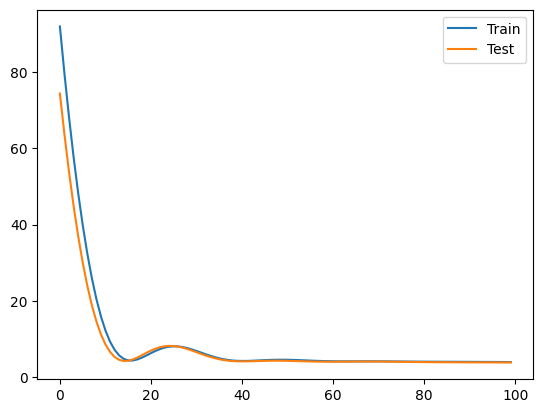

In [38]:
plt.plot([*range(num_epochs)],train_loss)
plt.plot([*range(num_epochs)],val_loss)
plt.legend(["Train","Test"])